In [1]:
import numpy as np
import pandas as pd

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split

import re
import nltk
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# from warnings import filterwarnings
# filterwarnings('ignore')

In [2]:
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Emincan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Emincan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Emincan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('english')
stop_word_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:
# WPT

In [5]:
df = pd.read_excel("comments.xlsx")
df

,nOrderId,comments,rating,status,date_created,sku,Customer ID,product_name,product_link,location,rating_avg,num_comments
0,44840,Very happy with thisğŸ˜Š,5,active,2022-11-28 19:20:34,3108,C0000921,Carina Collection Modern Washable Rugs in Pink...,https://www.the-rugs.com/washable-rugs/carina-...,NaN,5.000000,1
1,44840,NaN,5,active,2022-11-28 19:20:34,18185,C0000921,Muslera Collection Faux Fur Rugs in Light Grey...,https://www.the-rugs.com/bathroom-rugs/muslera...,NaN,5.000000,3
2,47071,Quality meets expectation,5,active,2022-11-26 21:06:08,2199,C0001003,Montana Collection Modern Rugs in Blue | 3762N...,https://www.the-rugs.com/modern-rugs/montana-c...,"Coventry, United Kingdom",5.000000,1
3,44681,"Just as the picture, creases came out quite qu...",5,active,2022-11-25 14:51:50,2169,C0020878,Montana Collection Modern Rugs in Cream | 3716...,https://www.the-rugs.com/vintage-rugs/montana-...,"Cardiff, United Kingdom",5.000000,3
4,44836,Beautiful Rug!!,5,active,2022-11-25 14:22:34,2470,C0009678,Rhapsody Collection Berber Design Shaggy Rugs ...,https://www.the-rugs.com/shaggy-rugs/rhapsody-...,"Slough, United Kingdom",5.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
556,13584,Absolutely lovely at extremely low price A* hi...,5,active,2020-05-06 20:18:47,48060,C0024000,MyShaggy Collection Shaggy Rugs in Off-White |...,https://www.the-rugs.com/shaggy-rugs/myshaggy-...,NaN,4.333333,3
557,13996,"Really nice rug, exactly as picture and great ...",5,active,2020-05-06 19:39:02,47480-my,C0008828,TREND Collection Modern Rugs in Beige | 7406B ...,https://www.the-rugs.com/striped-rugs/trend-co...,NaN,5.000000,1
558,14013,"Amazing rug! I loved the quality and softness,...",5,active,2020-05-06 19:33:21,49478,C0032499,Caimas Collection Washable Rugs in Blue | 6000...,https://www.the-rugs.com/washable-rugs/caimas-...,NaN,4.500000,2
559,13762,Good service and excellent quality products,5,active,2020-05-06 19:31:49,49206-my,C0000019,Caimas Collection Washable Rugs in Beige | 299...,https://www.the-rugs.com/abstract-rugs/caimas-...,NaN,5.000000,1


In [6]:
# def cleaning(data):
#     #1. Tokenize
#     text_tokens = word_tokenize(data.replace("'", "").lower())
#     #2. Remove Puncs and numbers
#     tokens_without_punc = [w for w in text_tokens if w.isalpha()]
#     #3. Removing Stopwords
#     tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
#     #4. lemma
#     text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
#     #joining
#     return " ".join(text_cleaned)

In [7]:
#the process of cleaning the punctuation marks found in our data
df["comments"] = df["comments"].apply(lambda x: re.sub('[,\.!?:()"Ÿ˜Š]', '', str(x)))
#conversion of uppercase letters to lowercase
df["comments"] = df["comments"].apply(lambda x: x.lower())
#cleaning of extra spaces
df["comments"] = df["comments"].apply(lambda x: x.strip())
#removal of stopwords contained in sentences
def token(comment):
    words = nltk.tokenize.word_tokenize(comment)
    filtered_words = [word for word in words if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc
df["comments"] = df["comments"].apply(lambda x: token(x))

In [8]:
df["comments"].head()

0                           happy thisğ
1                                   nan
2             quality meets expectation
3    picture creases came quite quickly
4                         beautiful rug
Name: comments, dtype: object

In [9]:
df = df[['comments','rating']]
df = df[df["comments"] != "nan"]
df.head()

,comments,rating
0,happy thisğ,5
2,quality meets expectation,5
3,picture creases came quite quickly,5
4,beautiful rug,5
6,pretty cosy pictures fits place soo well happy,5


In [10]:
df.shape

(456, 2)

In [11]:
df.rating.value_counts()

5    362
4     40
1     19
2     19
3     16
Name: rating, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  456 non-null    object
 1   rating    456 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.7+ KB


In [13]:
df['rating'] = df['rating'].map({5:1 , 4:1 , 1:0 , 2:0 , 3: np.nan})

In [14]:
df['rating'].value_counts(dropna=False)

1.0    402
0.0     38
NaN     16
Name: rating, dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.rating = df.rating.astype(np.int32)

In [17]:
df['rating'].value_counts(dropna=False)

1    402
0     38
Name: rating, dtype: int64

In [18]:
df["comments"].values.tolist()

['happy thisğ',
 'quality meets expectation',
 'picture creases came quite quickly',
 'beautiful rug',
 'pretty cosy pictures fits place soo well happy',
 'rug looks fresh clean looks lovely dining room',
 'lovely rug great quality good price',
 'delivery quick cost effective',
 'speed delivery product cost effective',
 'pleasantly surprised quality rug purchased nice rug fast delivery updates',
 'simply beautiful ğ\x8d',
 'excellent product looks great flags extension',
 'stunning rug exactly looking',
 'great rug perfect wanted go',
 'really happy rug excellent quality money excellent delivery time',
 'lovely rug good quality',
 'poor quality really disappointed sent straight back',
 "pretty fits well chaotic home office looks online 'm pleased washable great value may buy couple rooms house dogs find way",
 'bought 2 living room lovely especially dog easy enough throw washing mashine well dog loves eating biscuits',
 "'m really happy rug ordered yesterday arrived today dhl dhl kept 

In [19]:
df

,comments,rating
0,happy thisğ,1
2,quality meets expectation,1
3,picture creases came quite quickly,1
4,beautiful rug,1
6,pretty cosy pictures fits place soo well happy,1
...,...,...
556,absolutely lovely extremely low price * highly...,1
557,really nice rug exactly picture great quality,1
558,amazing rug loved quality softness brightness ...,1
559,good service excellent quality products,1


In [20]:
#df = df["comments"].values.tolist()
comments = df["comments"].values.tolist()
sentiments = df['rating'].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(comments,sentiments,test_size = 0.15, random_state = 53 , stratify=sentiments)

In [21]:
from collections import Counter

In [22]:
df["comments"]

0                                            happy thisğ
2                              quality meets expectation
3                     picture creases came quite quickly
4                                          beautiful rug
6         pretty cosy pictures fits place soo well happy
                             ...                        
556    absolutely lovely extremely low price * highly...
557        really nice rug exactly picture great quality
558    amazing rug loved quality softness brightness ...
559              good service excellent quality products
560    absolutely love new rug beautiful design good ...
Name: comments, Length: 440, dtype: object

In [23]:
all_words = " ".join(df["comments"])

In [24]:
all_words[:100]

'happy thisğ quality meets expectation picture creases came quite quickly beautiful rug pretty cosy p'

In [25]:
counter = Counter(word_tokenize(all_words)) # How many words(words) do we have, we're looking at this.
counter

Counter({'happy': 44,
         'thisğ': 1,
         'quality': 140,
         'meets': 1,
         'expectation': 1,
         'picture': 13,
         'creases': 2,
         'came': 8,
         'quite': 9,
         'quickly': 17,
         'beautiful': 36,
         'rug': 278,
         'pretty': 7,
         'cosy': 1,
         'pictures': 3,
         'fits': 10,
         'place': 5,
         'soo': 2,
         'well': 33,
         'looks': 91,
         'fresh': 1,
         'clean': 11,
         'lovely': 79,
         'dining': 1,
         'room': 37,
         'great': 131,
         'good': 95,
         'price': 72,
         'delivery': 70,
         'quick': 27,
         'cost': 4,
         'effective': 3,
         'speed': 3,
         'product': 24,
         'pleasantly': 4,
         'surprised': 5,
         'purchased': 9,
         'nice': 50,
         'fast': 17,
         'updates': 1,
         'simply': 1,
         'ğ\x8d': 2,
         'excellent': 49,
         'flags': 1,
         'ex

In [26]:
counter.most_common()

[('rug', 278),
 ('quality', 140),
 ('great', 131),
 ('good', 95),
 ('looks', 91),
 ('lovely', 79),
 ('price', 72),
 ('delivery', 70),
 ('really', 68),
 ('love', 56),
 ('nice', 50),
 ('excellent', 49),
 ('happy', 44),
 ('rugs', 41),
 ('value', 40),
 ('would', 39),
 ('soft', 38),
 ('room', 37),
 ('amazing', 37),
 ('beautiful', 36),
 ('colour', 36),
 ('service', 36),
 ('pleased', 35),
 ("n't", 35),
 ('recommend', 35),
 ('well', 33),
 ('one', 33),
 ('money', 31),
 ('bought', 30),
 ('like', 29),
 ('exactly', 28),
 ('itâ€™s', 28),
 ('quick', 27),
 ('perfect', 27),
 ("'s", 27),
 ('_x000d__x000d_', 27),
 ('looking', 25),
 ('size', 25),
 ('product', 24),
 ('thank', 24),
 ('time', 22),
 ('washable', 21),
 ('buy', 21),
 ('easy', 20),
 ('new', 20),
 ('arrived', 19),
 ('definitely', 19),
 ('get', 19),
 ('dog', 18),
 ('absolutely', 18),
 ('design', 18),
 ('delivered', 18),
 ('quickly', 17),
 ('fast', 17),
 ('customer', 17),
 ('look', 17),
 ('day', 17),
 ('also', 17),
 ('company', 16),
 ('perfectly',

In [27]:
tokenizer = Tokenizer(num_words = 10000)
# tokenizer.fit_on_texts(df['comments'])
tokenizer.fit_on_texts(comments)
tokenizer.word_index

{'rug': 1,
 'quality': 2,
 'x000d': 3,
 'great': 4,
 'good': 5,
 'looks': 6,
 'lovely': 7,
 'price': 8,
 'delivery': 9,
 'really': 10,
 'love': 11,
 'nice': 12,
 'excellent': 13,
 'happy': 14,
 'rugs': 15,
 'value': 16,
 'would': 17,
 'colour': 18,
 'soft': 19,
 'room': 20,
 'amazing': 21,
 'beautiful': 22,
 'service': 23,
 'pleased': 24,
 "n't": 25,
 'recommend': 26,
 'one': 27,
 'well': 28,
 'money': 29,
 'bought': 30,
 'like': 31,
 'exactly': 32,
 'perfect': 33,
 'itâ€™s': 34,
 'quick': 35,
 "'s": 36,
 'size': 37,
 'looking': 38,
 'product': 39,
 'thank': 40,
 'time': 41,
 'washable': 42,
 'buy': 43,
 'easy': 44,
 'new': 45,
 'arrived': 46,
 'definitely': 47,
 'get': 48,
 'slip': 49,
 'dog': 50,
 'absolutely': 51,
 'design': 52,
 'day': 53,
 'delivered': 54,
 'quickly': 55,
 'fast': 56,
 'customer': 57,
 'look': 58,
 'also': 59,
 'back': 60,
 'machine': 61,
 'outdoor': 62,
 'company': 63,
 'perfectly': 64,
 'wanted': 65,
 'living': 66,
 'ordered': 67,
 'next': 68,
 'washing': 69,
 '

In [28]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [29]:
num_tokens = [len(tokens) for tokens in X_train_tokens + X_test_tokens] # The number of individual tokens for each comment in the Train and Test comments
num_tokens = np.array(num_tokens)
num_tokens

array([ 8,  5,  6,  3, 11, 13,  6,  1,  5, 59, 23,  6, 16, 11,  1,  5, 11,
        3,  6,  5, 13,  3, 11, 10,  8, 60,  4,  3,  4, 18, 12, 16, 12, 26,
        3, 32, 19, 27, 10,  9, 22, 13,  3, 10, 10,  9, 24, 18,  6, 43, 41,
        5,  7, 23,  5,  7,  3, 21,  7,  5, 18,  2, 16,  2, 11, 18,  7, 15,
       28,  7, 11, 15,  4,  9, 19,  7, 36, 22, 12,  3, 14, 10, 14,  2, 32,
        4, 21,  3,  8,  7, 19,  7, 31,  4,  3,  5, 15,  6,  2, 16,  5,  5,
       10,  7,  3,  4, 15,  1,  2, 10,  8,  4, 17, 15, 19, 28,  8,  7,  5,
       12,  4,  4, 14,  6, 17,  6, 34, 10,  9,  6,  6, 12,  5,  8,  3,  5,
       17,  8, 10, 12,  8,  8, 17, 35, 26,  8, 18,  8,  5, 10,  9,  6,  5,
       25,  3, 11,  6,  1, 21, 87, 16,  4,  6, 10,  6,  4, 15, 27, 13, 14,
        4, 10,  9, 19, 19, 10, 19,  3,  2, 32, 10, 52, 14,  8,  6, 19, 15,
       28, 12,  6,  6, 33, 11,  7,  9,  3,  8,  8,  7,  6,  6, 16,  2,  9,
       18, 13, 18,  7, 13, 23, 16,  9,  6, 11, 10,  5,  4, 77,  5,  5,  6,
       10,  6, 13, 63,  7

In [30]:
# The maximum number of words that can be in a comment
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

34

In [31]:
num_tokens

array([ 8,  5,  6,  3, 11, 13,  6,  1,  5, 59, 23,  6, 16, 11,  1,  5, 11,
        3,  6,  5, 13,  3, 11, 10,  8, 60,  4,  3,  4, 18, 12, 16, 12, 26,
        3, 32, 19, 27, 10,  9, 22, 13,  3, 10, 10,  9, 24, 18,  6, 43, 41,
        5,  7, 23,  5,  7,  3, 21,  7,  5, 18,  2, 16,  2, 11, 18,  7, 15,
       28,  7, 11, 15,  4,  9, 19,  7, 36, 22, 12,  3, 14, 10, 14,  2, 32,
        4, 21,  3,  8,  7, 19,  7, 31,  4,  3,  5, 15,  6,  2, 16,  5,  5,
       10,  7,  3,  4, 15,  1,  2, 10,  8,  4, 17, 15, 19, 28,  8,  7,  5,
       12,  4,  4, 14,  6, 17,  6, 34, 10,  9,  6,  6, 12,  5,  8,  3,  5,
       17,  8, 10, 12,  8,  8, 17, 35, 26,  8, 18,  8,  5, 10,  9,  6,  5,
       25,  3, 11,  6,  1, 21, 87, 16,  4,  6, 10,  6,  4, 15, 27, 13, 14,
        4, 10,  9, 19, 19, 10, 19,  3,  2, 32, 10, 52, 14,  8,  6, 19, 15,
       28, 12,  6,  6, 33, 11,  7,  9,  3,  8,  8,  7,  6,  6, 16,  2,  9,
       18, 13, 18,  7, 13, 23, 16,  9,  6, 11, 10,  5,  4, 77,  5,  5,  6,
       10,  6, 13, 63,  7

In [32]:
np.sum(num_tokens < max_tokens) / len(num_tokens) # 95% of our comments are ideal comments that do not exceed the max word.

0.9568181818181818

In [33]:
#it is necessary to bring each comment to the same size, this is how RNN works.
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_tokens)
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_tokens)

In [34]:
X_train_pad[15]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   13,    2, 1132,   47,
         26])

In [35]:
# A function needs to be written in order for tokenized words to become strings again.

# idx = tokenizer.word_index
# inverse_map = dict(zip(idx.values(), idx.keys()))
# #tokenlaştırılan cümleyi tekrar string hale getirmek
# def tokens_to_string(tokens):
#     words = [inverse_map[token] for token in tokens if token !=0]
#     text = ' '.join(words)
#     return text

In [36]:
model = Sequential()
# A vector of length 50 is created corresponding to each word. (Embedding matrix)
embedding_size = 50
# The matrix will be the number of words and the size of the embedding, that is, it will be 10 by 50 long. This is also given a name with the name variable.
model.add(Embedding(input_dim=10000,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))
## LSTM with 16 neurons (with 16 outputs, return_sequences=True means give the entire output)
model.add(LSTM(units=16, return_sequences=True))
## LSTM with 8 neurons (with 8 outputs, return_sequences=True means give the entire output)
model.add(LSTM(units=8, return_sequences=True))
# LSTM with 4 neurons (with 4 outputs, return_sequences=False, i.e. the default value, will give a single output)
model.add(LSTM(units=4))
## The output layer is used when displaying the dense layer visually. Since it consists of a single neuron, it is written 1.
model.add(Dense(1,activation='sigmoid'))

# optimizer = Adam(lr=0.001)

# To compile the model, the loss function binary_crossentropy -> is used only for 2 classes, but categorical_crossentropy for more classes.

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              #optimizer=optimizer,
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 34, 50)            500000    
_________________________________________________________________
lstm (LSTM)                  (None, 34, 16)            4288      
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 8)             800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 505,301
Trainable params: 505,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Validation can be performed according to the situation

In [ ]:
# a = list()
# for x in y_train:
#     a.append(np.fromstring(x, dtype=np.int, sep=','))
# y_train = np.array(a)
# y_train

In [ ]:
# X_train_pad.shape

In [38]:
# Model training, going through the training once -> epoch, batch_size -> 16
history = model.fit(X_train_pad, np.array(y_train), epochs=50, batch_size=16)

Epoch 1/50
24/24 [==============================] - 3s 21ms/step - loss: 0.6548 - accuracy: 0.8743
Epoch 2/50
24/24 [==============================] - 1s 23ms/step - loss: 0.4692 - accuracy: 0.9144
Epoch 3/50
24/24 [==============================] - 1s 23ms/step - loss: 0.3458 - accuracy: 0.9144
Epoch 4/50
24/24 [==============================] - 1s 23ms/step - loss: 0.3031 - accuracy: 0.9144
Epoch 5/50
24/24 [==============================] - 1s 23ms/step - loss: 0.2892 - accuracy: 0.9144
Epoch 6/50
24/24 [==============================] - 1s 23ms/step - loss: 0.2772 - accuracy: 0.9144
Epoch 7/50
24/24 [==============================] - 1s 23ms/step - loss: 0.2451 - accuracy: 0.9225
Epoch 8/50
24/24 [==============================] - 1s 23ms/step - loss: 0.1939 - accuracy: 0.9412
Epoch 9/50
24/24 [==============================] - 1s 24ms/step - loss: 0.1424 - accuracy: 0.9572
Epoch 10/50
24/24 [==============================] - 1s 22ms/step - loss: 0.1122 - accuracy: 0.9679
Epoch 11/

In [39]:
history.history

{'loss': [0.6547588109970093,
  0.46924281120300293,
  0.3457741141319275,
  0.3031325042247772,
  0.2891710102558136,
  0.2771594524383545,
  0.24508854746818542,
  0.19390900433063507,
  0.14235450327396393,
  0.11222922056913376,
  0.10956724733114243,
  0.09172575175762177,
  0.07899962365627289,
  0.06984329968690872,
  0.06490433216094971,
  0.05901704356074333,
  0.05544529855251312,
  0.05224010720849037,
  0.04859570041298866,
  0.04416102543473244,
  0.04075254499912262,
  0.041302070021629333,
  0.039160020649433136,
  0.033584967255592346,
  0.031806375831365585,
  0.030106376856565475,
  0.027243943884968758,
  0.025426430627703667,
  0.02413894794881344,
  0.022627713158726692,
  0.02234368585050106,
  0.02123127691447735,
  0.018704691901803017,
  0.017602570354938507,
  0.016443129628896713,
  0.015666143968701363,
  0.015805082395672798,
  0.01437484659254551,
  0.01401576865464449,
  0.012901749461889267,
  0.012191811576485634,
  0.011734959669411182,
  0.01111115887

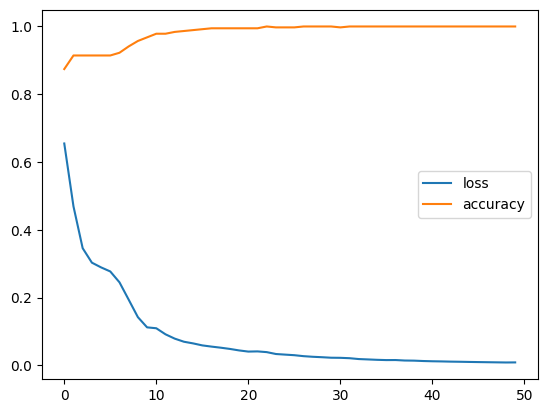

In [40]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot();

In [ ]:
# Done